In [240]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [241]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = _children
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

In [242]:
a = Value(3.0, label='a')
b = Value(2.0, label='b')
c = Value(4.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-1.0, label='f')
L = d * f; L.label='L'

In [243]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set() 
  def build(i):
    if i not in nodes:
      nodes.add(i)
      for child in i._prev:
        edges.add((child, i))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label="{ %s | data %.4f | grad %.4f}" % (n.label , n.data, n.grad), shape='record')
    if n._op:
      # creating node/edge for an operation
      dot.node(name = uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

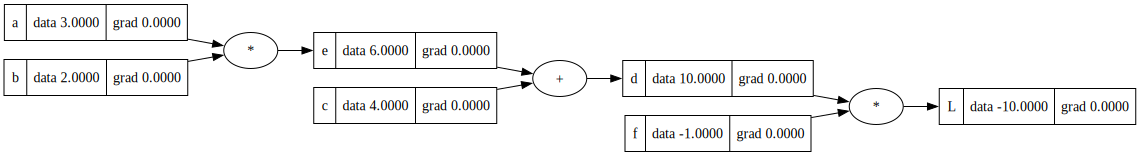

In [244]:
draw_dot(L)

In [256]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

In [ ]:
# output grad
o.grad = 1.0

# topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

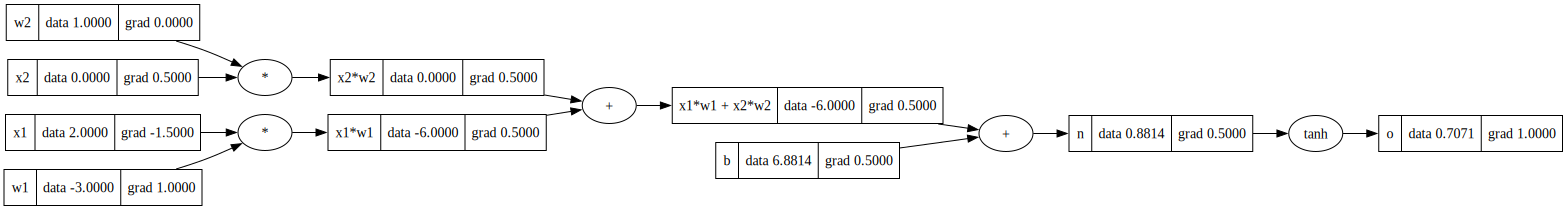

In [258]:
draw_dot(o)